## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

ModuleNotFoundError: No module named 'yfinance'

## 1. Mengambil Data Historis XRP (Ripple)

In [11]:
data = yf.download('XRP-USD', start='2015-01-01', end='2024-12-11')

# Menampilkan data
data.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,XRP-USD,XRP-USD,XRP-USD,XRP-USD,XRP-USD,XRP-USD
Date,,,,,,
2017-11-09,0.217488,0.217488,0.221791,0.214866,0.217911,147916992
2017-11-10,0.206483,0.206483,0.219068,0.205260,0.218256,141032992
2017-11-11,0.210430,0.210430,0.214456,0.205459,0.205948,134503008
2017-11-12,0.197339,0.197339,0.210214,0.195389,0.210214,251175008
2017-11-13,0.203442,0.203442,0.204081,0.197456,0.197472,132567000


## 2. Preprocessing Data

In [12]:
data_close = data['Close'].values
data_close = data_close.reshape(-1, 1)

# Normalisasi data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_close)

# Membuat data latih dan data uji
train_size = int(len(data_scaled) * 0.8)
train_data, test_data = data_scaled[:train_size], data_scaled[train_size:]

# Fungsi untuk membuat dataset dengan langkah waktu tertentu
def create_dataset(data, time_step=60):
    x, y = [], []
    for i in range(len(data) - time_step - 1):
        x.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(x), np.array(y)

# Membuat data latih dan data uji
time_step = 60
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

# Reshaping data untuk input ke LSTM (batch_size, time_steps, features)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

## 3. Membangun Model LSTM

In [13]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))

## 4. Kompilasi Model

In [14]:
model.compile(optimizer='adam', loss='mean_squared_error')

## 5. Melatih Model

In [15]:
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/10
63/63 [==============================] - 4s 28ms/step - loss: 0.0020 - val_loss: 9.8944e-04
Epoch 2/10
63/63 [==============================] - 1s 22ms/step - loss: 7.5066e-04 - val_loss: 8.0852e-04
Epoch 3/10
63/63 [==============================] - 1s 23ms/step - loss: 6.0409e-04 - val_loss: 7.9637e-04
Epoch 4/10
63/63 [==============================] - 1s 23ms/step - loss: 5.3303e-04 - val_loss: 5.8334e-04
Epoch 5/10
63/63 [==============================] - 1s 23ms/step - loss: 4.6798e-04 - val_loss: 5.2402e-04
Epoch 6/10
63/63 [==============================] - 1s 22ms/step - loss: 4.4724e-04 - val_loss: 4.5244e-04
Epoch 7/10
63/63 [==============================] - 1s 22ms/step - loss: 4.3648e-04 - val_loss: 4.2367e-04
Epoch 8/10
63/63 [==============================] - 1s 22ms/step - loss: 3.5808e-04 - val_loss: 4.1957e-04
Epoch 9/10
63/63 [==============================] - 1s 22ms/step - loss: 3.4479e-04 - val_loss: 3.4256e-04
Epoch 10/10
63/63 [======================

## 6. Prediksi Harga XRP ke Depan (30 Hari)

1/1 [==============================] - 0s 18ms/step


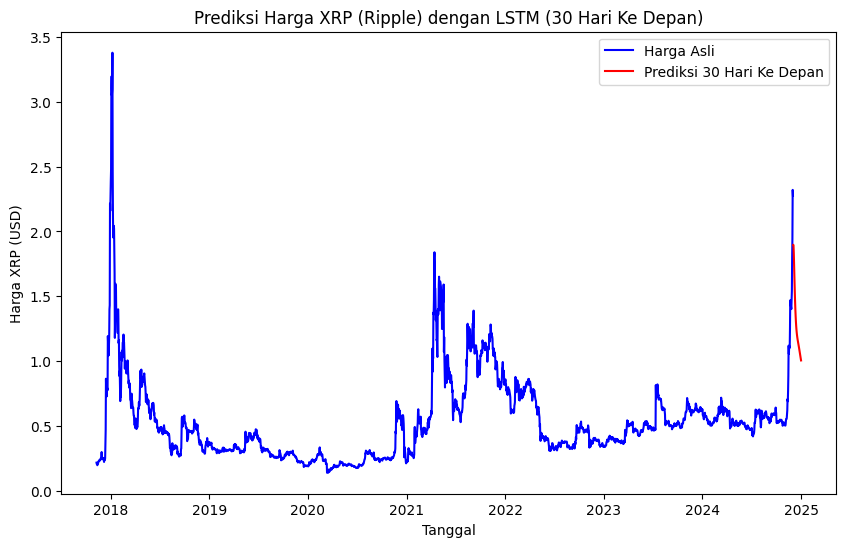

Prediksi Harga XRP untuk 30 Hari Ke Depan:
2024-12-03: $1.90
2024-12-04: $1.89
2024-12-05: $1.84
2024-12-06: $1.76
2024-12-07: $1.68
2024-12-08: $1.60
2024-12-09: $1.52
2024-12-10: $1.45
2024-12-11: $1.39
2024-12-12: $1.35
2024-12-13: $1.30
2024-12-14: $1.27
2024-12-15: $1.24
2024-12-16: $1.22
2024-12-17: $1.20
2024-12-18: $1.18
2024-12-19: $1.17
2024-12-20: $1.16
2024-12-21: $1.15
2024-12-22: $1.13
2024-12-23: $1.12
2024-12-24: $1.11
2024-12-25: $1.10
2024-12-26: $1.08
2024-12-27: $1.07
2024-12-28: $1.06
2024-12-29: $1.04
2024-12-30: $1.03
2024-12-31: $1.02
2025-01-01: $1.01


In [16]:
def predict_future_days(model, last_60_days, future_days=30):
    future_prices = []
    current_input = last_60_days.reshape(1, -1)
    current_input = current_input.reshape((current_input.shape[0], current_input.shape[1], 1))
    
    for _ in range(future_days):
        predicted_price = model.predict(current_input)
        future_prices.append(predicted_price[0][0])
        
        # Update input untuk prediksi berikutnya
        current_input = np.append(current_input[:, 1:, :], predicted_price.reshape(1, 1, 1), axis=1)

    return future_prices

# Mengambil data terakhir (60 hari terakhir)
last_60_days = data_scaled[-60:]

# Prediksi 30 hari ke depan
predicted_future_prices = predict_future_days(model, last_60_days, future_days=30)

# Mengembalikan prediksi ke skala asli
predicted_future_prices = scaler.inverse_transform(np.array(predicted_future_prices).reshape(-1, 1))

# Menampilkan hasil prediksi
predicted_dates = pd.date_range(start=data.index[-1], periods=31, freq='D')[1:]

plt.figure(figsize=(10,6))
plt.plot(data.index, scaler.inverse_transform(data_scaled), color='blue', label='Harga Asli')
plt.plot(predicted_dates, predicted_future_prices, color='red', label='Prediksi 30 Hari Ke Depan')
plt.title('Prediksi Harga XRP (Ripple) dengan LSTM (30 Hari Ke Depan)')
plt.xlabel('Tanggal')
plt.ylabel('Harga XRP (USD)')
plt.legend()
plt.show()

print("Prediksi Harga XRP untuk 30 Hari Ke Depan:")
for date, price in zip(predicted_dates, predicted_future_prices):
    print(f"{date.date()}: ${price[0]:.2f}")